#Import The Moduls

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Dense, Flatten, InputLayer,
                                     BatchNormalization,Input,Layer,
                                     Dropout,Resizing,Rescaling,RandomRotation,
                                     RandomFlip,RandomContrast,MaxPooling2D,GlobalAveragePooling2D,Add,Activation)
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy , SparseCategoricalCrossentropy
from tensorflow.keras.metrics import (BinaryAccuracy , FalsePositives,FalseNegatives,
                                      TruePositives,TrueNegatives,Precision,Recall,AUC,
                                      CategoricalAccuracy,TopKCategoricalAccuracy)
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.regularizers import L1,L2
from tensorflow.image import (flip_left_right,random_flip_up_down,rot90,adjust_brightness
                              ,random_saturation,central_crop,adjust_saturation,
                              crop_to_bounding_box,pad_to_bounding_box)
from tensorflow.train import BytesList,FloatList,Int64List,Example,Features,Feature
import sklearn as sl
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
import numpy as np
import cv2
from google.colab import drive

#Data Management


##Download Data

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 98% 304M/309M [00:01<00:00, 193MB/s]
100% 309M/309M [00:01<00:00, 168MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

##Dataset Loading

###Directory

In [ ]:
train_dic = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_dic = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IMG_SIZE": 254,
    "LEARNING_RATE": 1e-3,

    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

###Train,Validation - Data

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
    val_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


#Data Visualization

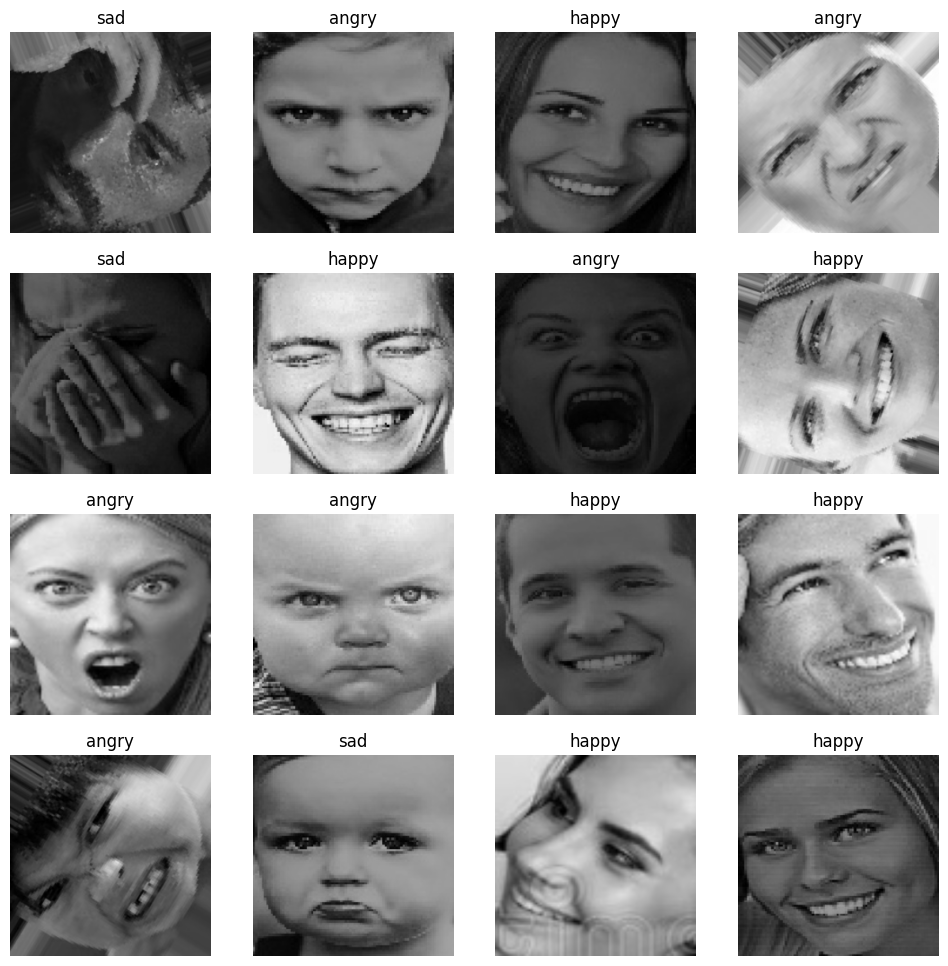

In [ ]:
plt.figure(figsize = (12,12))
for images , label in train_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(label[i],axis = 0).numpy()])
    plt.axis("off")

#Data Augmantation

##Data Augmantation using layer

In [ ]:
augmantation_layer = Sequential([
    RandomRotation(factor = (-0.025,0.025),),
    RandomFlip(mode = 'horizontal',),
    RandomContrast(factor=0.1)
])

In [ ]:
def augmantation(image,label):
    return augmantation_layer(image,training = True),label

##Cut-Mix Data Augmantation

In [ ]:
IM_SIZE = CONFIGURATION["IMG_SIZE"]

def box(lamda):
    r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype=tf.int32)
    r_w = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_h = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype=tf.int32)
    r_x = tf.clip_by_value(r_x - r_w // 2, 0, IM_SIZE)
    r_y = tf.clip_by_value(r_y - r_h // 2, 0, IM_SIZE)
    x_b_r = tf.clip_by_value(r_x + r_w // 2, 0, IM_SIZE)
    y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, IM_SIZE)
    r_w = x_b_r - r_x
    if r_w == 0:
        r_w = 1
    r_h = y_b_r - r_y
    if r_h == 0:
        r_h = 1
    return r_y, r_x, r_h, r_w

In [ ]:
def mixup(train_dataset_1,train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    r_y, r_x, r_h, r_w = box(lamda)

    image_1_crop = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    image_1_crop_padding = tf.image.pad_to_bounding_box(image_1_crop, r_y, r_x, IM_SIZE, IM_SIZE)

    image_2_crop = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    image_2_crop_padding = tf.image.pad_to_bounding_box(image_2_crop, r_y, r_x, IM_SIZE, IM_SIZE)

    mixed_image = image_1 - image_1_crop_padding + image_2_crop_padding

    mixed_label = lamda * label_1 + (1 - lamda) * label_2

    return mixed_image, mixed_label

In [ ]:
train_data_1 = train_data.map(augmantation,num_parallel_calls = tf.data.AUTOTUNE)
train_data_2 = train_data.map(augmantation,num_parallel_calls = tf.data.AUTOTUNE)

mixed_data = tf.data.Dataset.zip((train_data_1,train_data_2))

#Data Preparation

In [ ]:
train_data = (
    train_data
    .map(augmantation,num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_data = (
    train_data
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
training_data = (
    mixed_data
    .map(mixup,num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_data = (
    val_data
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layer = Sequential([
    Resizing(CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"]),
    Rescaling(1./255),
])

#TFRecords

## Encode The Records

In [ ]:
train_data = (
    train_data
    .unbatch()
)

In [ ]:
validation_data = (
    val_data
    .unbatch()
)

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_data
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

## Decode The Records

In [ ]:
!cp -r /content/drive/MyDrive/datasetwithtfrecoeds /content/tfrecords

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
parshed_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#Modeling

##Sequential

In [ ]:
lenet_model = Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layer,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

##ResNet-34

###CustomConv2D


In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

###Residual Block

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


###Full Network

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

#Training

In [ ]:
#loss_function =  SparseCategoricalCrossentropy()
loss_function = CategoricalCrossentropy()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weigths.{epoch:02h}-{val_loss:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    )

In [ ]:
matric = [SparseCategoricalCrossentropy(name="accuracy"),TopKCategoricalAccuracy(k = 2,name = "top_k_accuracy")]

In [ ]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics=matric
)

In [ ]:
history = lenet_model.fit(
    train_data,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

In [ ]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = 'accuracy'
)

In [ ]:
history = resnet_34.fit(
    train_data,
    epochs = 10,
    verbose = 1
)

Epoch 1/10
213/213 [==============================] - 43s 199ms/step - loss: 0.1765 - accuracy: 0.9368
Epoch 2/10
213/213 [==============================] - 45s 210ms/step - loss: 0.1736 - accuracy: 0.9412
Epoch 3/10
213/213 [==============================] - 44s 203ms/step - loss: 0.1589 - accuracy: 0.9423
Epoch 4/10
213/213 [==============================] - 44s 206ms/step - loss: 0.1567 - accuracy: 0.9415
Epoch 5/10
213/213 [==============================] - 45s 208ms/step - loss: 0.1361 - accuracy: 0.9516
Epoch 6/10
213/213 [==============================] - 45s 209ms/step - loss: 0.1822 - accuracy: 0.9366
Epoch 7/10
213/213 [==============================] - 45s 210ms/step - loss: 0.1310 - accuracy: 0.9529
Epoch 8/10
213/213 [==============================] - 44s 207ms/step - loss: 0.1292 - accuracy: 0.9544
Epoch 9/10
213/213 [==============================] - 44s 205ms/step - loss: 0.1223 - accuracy: 0.9557
Epoch 10/10
213/213 [==============================] - 44s 207ms/step - l

#Visulization

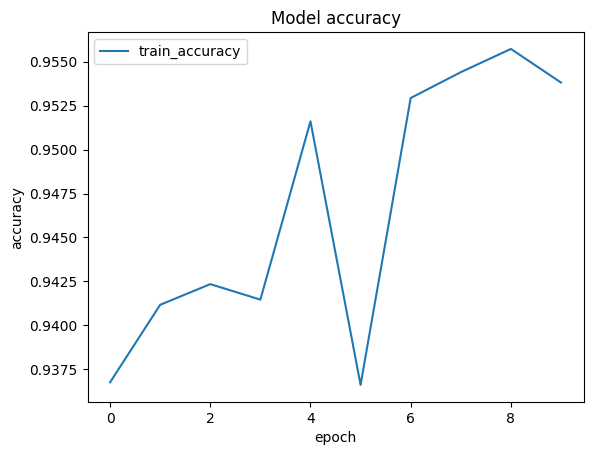

In [ ]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'])#, 'val_accuracy'])
plt.show()

#Evaluate Model

In [ ]:
lenet_model.evaluate(val_data)

72/72 [==============================] - 5s 53ms/step - loss: 0.6245 - accuracy: 0.7673 - top_k_accuracy: 0.9258


[0.6244692802429199, 0.7673397660255432, 0.9258121252059937]

In [ ]:
resnet_34.evaluate(val_data)

72/72 [==============================] - 6s 67ms/step - loss: 0.9317 - accuracy: 0.6738


[0.9317011833190918, 0.6738367080688477]

#Testing

In [ ]:
plt.figure(figsize = (12,12))
for images , label in val_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title("ACTUAL:-"+CONFIGURATION["CLASS_NAMES"][tf.argmax(label[i],axis = 0).numpy()]+"\n"+"PREDICT:-"+CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(tf.expand_dims(images[i],axis = 0)),axis = -1).numpy()[0]])
    plt.axis("off")

Text(0.5, 1.0, 'happy')

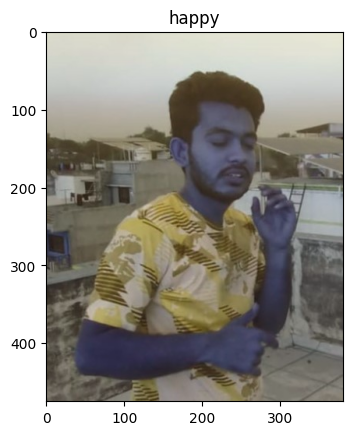

In [ ]:
test_img_path = cv2.imread("/content/12.jpg")
test_img = tf.constant(test_img_path,dtype=tf.float32)
test_img = tf.expand_dims(test_img,axis = 0)
plt.imshow(test_img_path)
plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(resnet_34(test_img),axis = -1).numpy()[0]])

In [ ]:
plt.figure(figsize = (12,12))
for images , label in val_data.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title("ACTUAL:-"+CONFIGURATION["CLASS_NAMES"][tf.argmax(label[i],axis = 0).numpy()]+"\n"+"PREDICT:-"+CONFIGURATION["CLASS_NAMES"][tf.argmax(lenet_model(tf.expand_dims(images[i],axis = 0)),axis = -1).numpy()[0]])
    plt.axis("off")

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

#Confusion Matrix

In [ ]:
predict = []
label_list = []
for im, labels in val_data:
    predict.append(resnet_34(im))
    label_list.append(labels.numpy())

In [ ]:
pred = np.concatenate([np.argmax(predict[:-1],axis = -1).flatten(),np.argmax(predict[-1],axis = -1).flatten()])
lab = np.concatenate([np.argmax(label_list[:-1],axis = -1).flatten(),np.argmax(label_list[-1],axis = -1).flatten()])

[[369  56  90]
 [ 54 840 112]
 [ 87  90 580]]


Text(0.5, 58.7222222222222, 'Predict')

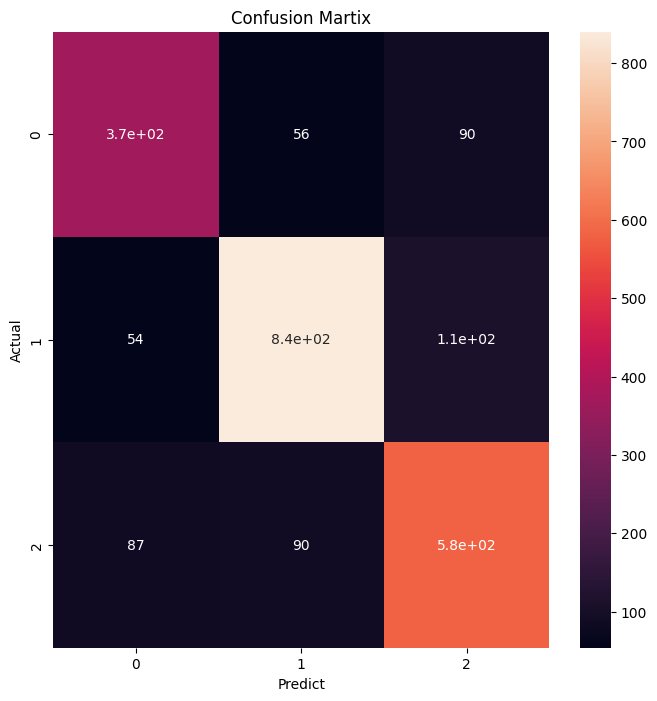

In [ ]:
cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,)
plt.title(f'Confusion Martix')
plt.ylabel('Actual')
plt.xlabel('Predict')

#Save The Model

In [ ]:
lenet_model.save("lenetmodel")

In [ ]:
load_lenet_model = tf.keras.models.load_model('lenetmodel')
load_lenet_model.summary()

In [ ]:
load_lenet_model.evaluate(val_data)

72/72 [==============================] - 6s 60ms/step - loss: 0.6895 - accuracy: 0.7599 - top_k_accuracy: 0.9232


[0.689465343952179, 0.75987708568573, 0.9231782555580139]

In [ ]:
lenet_model.save("lenetmodel.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/lenetmodel /content/drive/MyDrive/lenet_colab

cp: cannot stat '/content/lenetmodel': No such file or directory


In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab /content/lenetmodel